# Animal clustering using computer vision

The purpose of this clustering is to ID different animals to support feed measurement. We collected 904 images from the cameras above the feed bunks and cropped the small regions of interets as our first dataset (DS1). This is not the only way. We can also use the fully animal body using MaskRCNN. You will see in the following experiements that the animals put their heads down to feed, making it difficult to see their features. 

The following is the general steps:
1. Collect images to be clustered.
2. Modify a pre-trained ResNet model to extract the feature (2048x1) from the last layer.
3. Apply the modified ResNet on each image to form a matrix (904x2048) where each row is one sample and feature vector is the column values.
4. Use k-means, DBscan, and GMM methods to cluster and visualize.

In [37]:
import os
import numpy as np
from random import randint
import pickle
# import seaborn as sns
from PIL import Image, ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# clustering and dimension reduction
from sklearn.cluster import KMeans, DBSCAN

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import cv2
import torch
from torchvision import models, transforms

# Get a list of all the images

In [2]:
directory_path = 'D:/Dataset - Bunk 3-20230921T142857Z-001/Dataset - Bunk 3/'  # Replace with the path to your directory
images=[]
# Print the list of files
for file in os.listdir(directory_path) :
    file_path=(os.path.join(directory_path, file))
    image=cv2.imread(file_path)
    images.append(image)
image_data = np.array(images)
len(os.listdir(directory_path))

904

In [3]:
len(image_data)

904

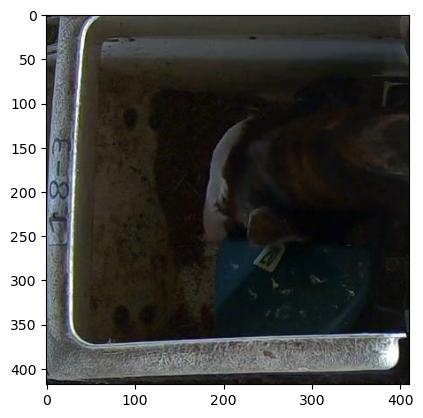

In [4]:
plt.imshow(image_data[500])

# Resnet classification

Resnet pre-trained on ImageNet dataset with 1000 classes hence the pridiction shape is 1000 dimensional.

In [5]:
# Load a pre-trained ResNet model (e.g., ResNet-50)
resnet = models.resnet50(pretrained=True)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = transform(Image.fromarray(image))
image = image.unsqueeze(0)  # Add a batch dimension (required by the model)
# Forward pass to extract features
with torch.no_grad():
    out = resnet(image)
out.shape

C:\Users\piyalong\AppData\Local\anaconda3\envs\jupyterlab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\piyalong\AppData\Local\anaconda3\envs\jupyterlab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 1000])

# Load 1000 class names from Github

This is a long list. You can check it out.

In [6]:
import requests
master = "https://gist.githubusercontent.com/TAMIDSpiyalong/69d949157e90dcee1d8e730b74887931/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
req = requests.get(master)
idx2label  = eval(req.text)
for idx in out[0].sort()[1][-10:]:
    print(idx2label[int(idx)],   idx, out[0][idx])

television, television system tensor(851) tensor(6.6234)
dishwasher, dish washer, dishwashing machine tensor(534) tensor(6.7121)
soap dispenser tensor(804) tensor(6.7139)
refrigerator, icebox tensor(760) tensor(6.9231)
medicine chest, medicine cabinet tensor(648) tensor(7.1124)
screen, CRT screen tensor(782) tensor(7.1356)
washbasin, handbasin, washbowl, lavabo, wash-hand basin tensor(896) tensor(8.6913)
bathtub, bathing tub, bath, tub tensor(435) tensor(9.8206)
tub, vat tensor(876) tensor(9.9404)
tray tensor(868) tensor(12.1895)


In [7]:
sortedProba = torch.argsort(out, dim=-1, descending=True)
for idx in sortedProba[0][:10]:
    print(idx2label[int(idx)],   idx, out[0][idx])

tray tensor(868) tensor(12.1895)
tub, vat tensor(876) tensor(9.9404)
bathtub, bathing tub, bath, tub tensor(435) tensor(9.8206)
washbasin, handbasin, washbowl, lavabo, wash-hand basin tensor(896) tensor(8.6913)
screen, CRT screen tensor(782) tensor(7.1356)
medicine chest, medicine cabinet tensor(648) tensor(7.1124)
refrigerator, icebox tensor(760) tensor(6.9231)
soap dispenser tensor(804) tensor(6.7139)
dishwasher, dish washer, dishwashing machine tensor(534) tensor(6.7121)
television, television system tensor(851) tensor(6.6234)


In [8]:
sortedProba.shape

torch.Size([1, 1000])

# Resnet as feature extractor

In [11]:
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

output = feature_extractor(image) # output now has the features corresponding to input x
print(output.shape)

torch.Size([1, 2048, 1, 1])


Here we are using only the layer before the last output layer, i.e., 1000 dimensional output corresponding to each class.

In [12]:
features=[]
for file in os.listdir(directory_path) :
    file_path=(os.path.join(directory_path, file))
    image=cv2.imread(file_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = transform(Image.fromarray(image))
    image = image.unsqueeze(0)  # Add a batch dimension (required by the model)
    feature = feature_extractor(image) # output now has the features corresponding to input x
    features.append(feature.detach().numpy()[0][:][:])
    # break

In [13]:
len(features)

904

In [14]:
np.array(features).shape

(904, 2048, 1, 1)

In [15]:
np.array(features)[:,:,0,0].shape

(904, 2048)

We get 904 images therefore a 904x2048 dimensional vector representing all images. Now we use T-SNE to look at the images in a 2D space. Here the similar images will appear closer to each other. 

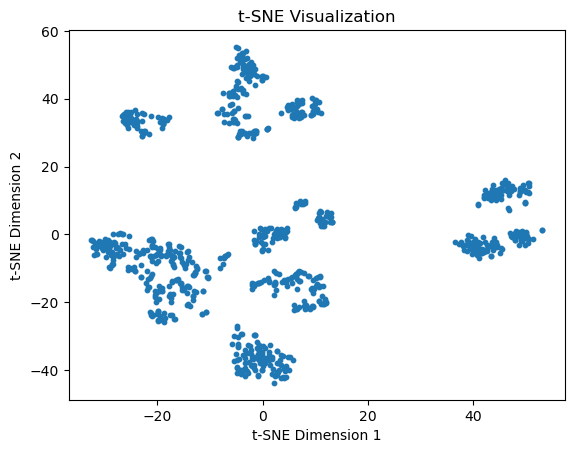

In [16]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Generate or load your data, assuming it's a (904, 2048) numpy array
# Replace this with your actual data loading or generation logic
data = np.array(features)[:,:,0,0]

# Initialize t-SNE with the desired number of components (2 for 2D visualization)
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform your data to reduce it to 2 dimensions
tsne_result = tsne.fit_transform(data)

# Create a scatter plot to visualize the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)  # s controls point size
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()


In [17]:
tsne_result.shape

(904, 2)

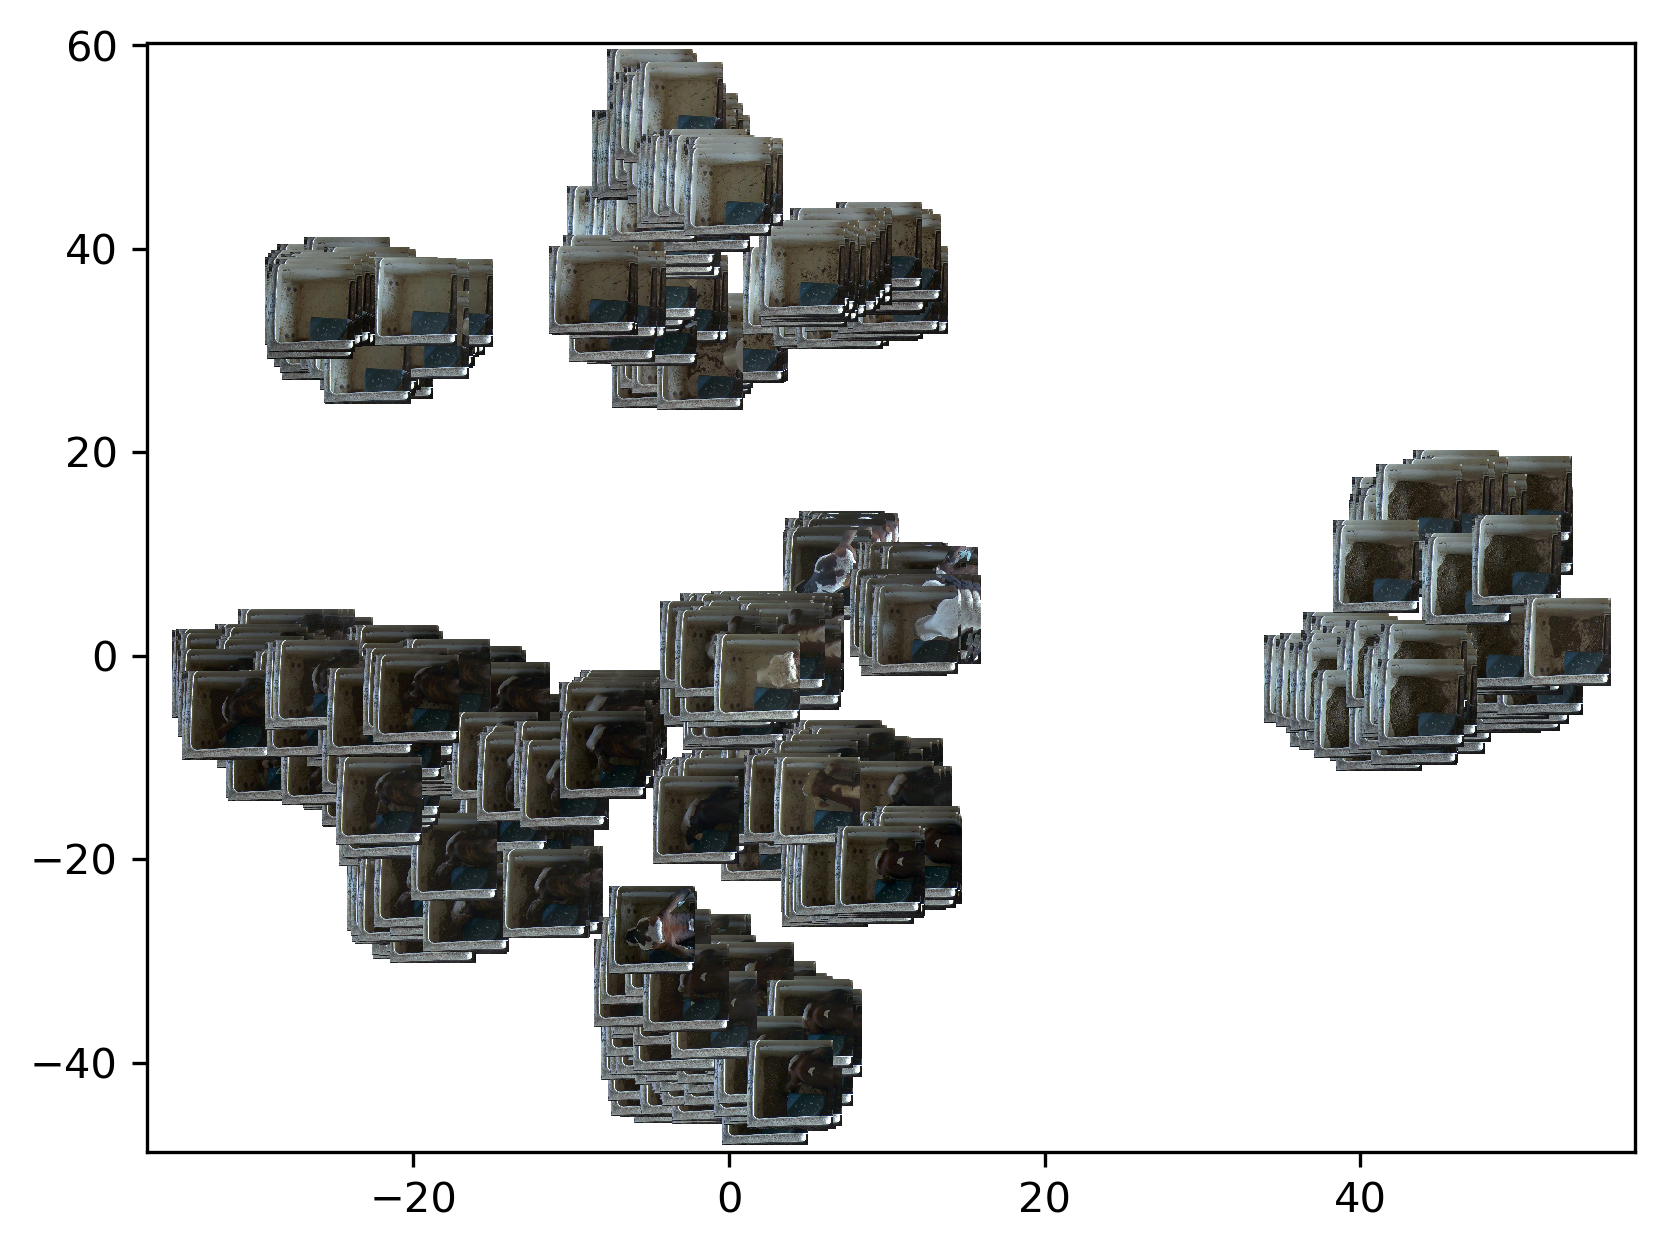

In [78]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(dpi=300)

ax.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10)  # s controls point size

for i in range(len(images)):
    imagebox = OffsetImage(images[i], zoom=0.05)  # Adjust the zoom factor as needed
    ab = AnnotationBbox(imagebox, tsne_result[i], frameon=False, pad=0)
    ax.add_artist(ab)

# K-means

k-means methos requires us to define the cluster number. We do not know how many animals are inside in advance.

But in this case, we know there are three types by looking at them:
* with animal
* empty
* full

518
151
235


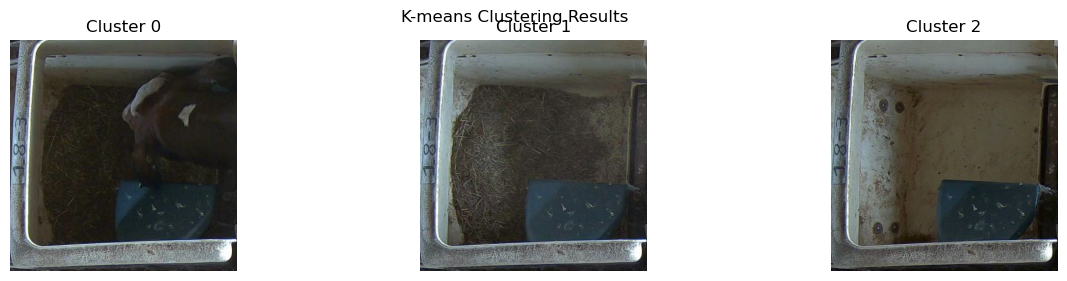

In [19]:
# Define the number of clusters (K)
num_clusters = 3  # Adjust this to your desired number of clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(tsne_result)

# Create subplots to display images from each cluster
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))

for cluster_id in range(num_clusters):
    cluster_images = image_data[cluster_labels == cluster_id]
    print(len(cluster_images))
    # Choose a representative image from the cluster (e.g., the first one)
    sample_image = cluster_images[0]

    # Display the sample image
    axes[cluster_id].imshow(sample_image)
    axes[cluster_id].set_title(f'Cluster {cluster_id}')

for ax in axes:
    ax.axis('off')

plt.suptitle('K-means Clustering Results')
plt.show()

In [22]:
cluster_one_indices = np.where(cluster_labels == 0)[0]

In [29]:
cluster_one_indices[0]

205

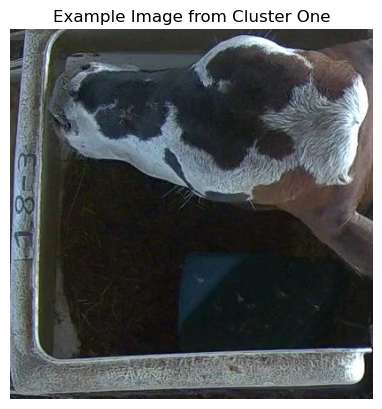

In [31]:
example_image = image_data[cluster_one_indices[50]]

# Display the example image
plt.imshow(example_image)
plt.title('Example Image from Cluster One')
plt.axis('off')  # Turn off axis labels
plt.show()

For the second round we do k-means clustering again. This time we try to differetiate different animals.

42
66
43
47
73
38
47
35
67
60


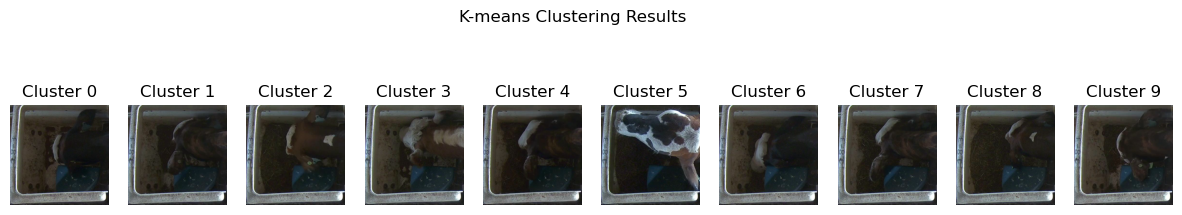

In [35]:
cluster_one=tsne_result[cluster_one_indices]
cluster_one_images=image_data[cluster_one_indices]

# Define the number of clusters (K)
num_clusters = 10  # Adjust this to your desired number of clusters

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(cluster_one)

# Create subplots to display images from each cluster
fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))

for cluster_id in range(num_clusters):
    cluster_images = cluster_one_images[cluster_labels == cluster_id]
    print(len(cluster_images))
    # Choose a representative image from the cluster (e.g., the first one)
    sample_image = cluster_images[0]

    # Display the sample image
    axes[cluster_id].imshow(sample_image)
    axes[cluster_id].set_title(f'Cluster {cluster_id}')

for ax in axes:
    ax.axis('off')

plt.suptitle('K-means Clustering Results')
plt.show()


# DBSCAN

DBSCAN is a frequency based tool and that does not require us to set a fixed class number. This works for us because we do not know. We can test out all the eps distance parameters and apply that to all other images.

110
38
234
89
47


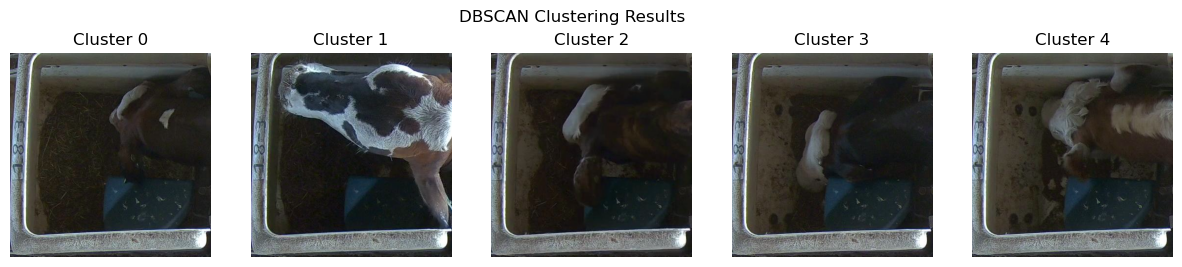

In [50]:
# Apply PCA to reduce the dimensionality (optional but can improve performance)
# pca = PCA(n_components=50)  # You can adjust the number of components as needed
# image_data_pca = pca.fit_transform(data)

# Perform DBSCAN clustering
db = DBSCAN(eps=5, min_samples=5)  # You can adjust 'eps' and 'min_samples' as needed
cluster_labels = db.fit_predict(cluster_one)

# Create subplots to display images from each cluster
unique_labels = np.unique(cluster_labels)
num_clusters = len(unique_labels)

fig, axes = plt.subplots(1, num_clusters, figsize=(15, 3))

for cluster_id, ax in zip(unique_labels, axes):
    cluster_images = cluster_one_images[cluster_labels == cluster_id]
    print(len(cluster_images))
    for i,img in enumerate(cluster_images):
        cv2.imwrite('DS1_clusters/Cluster'+str(cluster_id)+'_Number'+str(i)+'.jpg',img)
    # Choose a representative image from the cluster (e.g., the first one)
    if len(cluster_images) > 0:
        sample_image = cluster_images[0]

        # Display the sample image
        ax.imshow(sample_image)
        ax.set_title(f'Cluster {cluster_id}')
    else:
        ax.axis('off')
        ax.set_title(f'Cluster {cluster_id} (Empty)')

for ax in axes:
    ax.axis('off')

plt.suptitle('DBSCAN Clustering Results')
plt.show()

(904, 2048)

# Conclusion

The models suggests 5 different animals observed. Cluster 3 and 4 are well seperated but the rest is not clear. Using only the head shot images works to some degree but not all the time. Especially when animals head down to feed. The next step is use the full body. This requires MaskRCNN mask extraction first. The rest will follow the same steps as in this jupyter file.